<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_Interfacial_Thermal_Resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Libs

In [72]:
!pip install -q import_ipynb

In [73]:
# utils
import os, sys, warnings, itertools, tarfile
import import_ipynb
import pandas as pd
import numpy as np
from six.moves import urllib
# colab
from google.colab import drive
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, FunctionTransformer)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import (ColumnTransformer, make_column_transformer)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
# vis
import seaborn as sns
import matplotlib.pyplot as plt

### Settings

In [74]:
warnings.filterwarnings('ignore')

In [75]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [77]:
# module dir
module_path = os.path.abspath(os.path.join("./"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [78]:
# load MachineLearningUtils module
from MachineLearningUtils import *

## Process Data

#### Load Data

In [79]:
data_dir = "Inputs/InterfacialThermalResistance"

In [80]:
df = pd.read_excel(os.path.join(data_dir, 'training dataset for ITR prediction.xlsx'))
df.drop(['id-t', 'Interface'], axis=1, inplace=True)
df

,Film,substrate,interlayer1,interlayer2,interlayer,T,fthick,fheatcap,fmelt,fdensity,...,sAC1y,sAC2x,sAC2y,sENc,sENa,sIPc,sIPa,sEb,smass,itr
0,Au,Si,SiO2,NaN,1,100,80.0,0.111941,1337,19.3,...,3,14,3,1.90,1.90,8.151,8.151,-4.622464,28.09,26.315789
1,Au,Si,SiO2,NaN,1,150,80.0,0.119712,1337,19.3,...,3,14,3,1.90,1.90,8.151,8.151,-4.622464,28.09,24.390244
2,Au,Si,SiO2,NaN,1,200,80.0,0.122658,1337,19.3,...,3,14,3,1.90,1.90,8.151,8.151,-4.622464,28.09,25.641026
3,Au,Si,SiO2,NaN,1,250,80.0,0.124065,1337,19.3,...,3,14,3,1.90,1.90,8.151,8.151,-4.622464,28.09,22.727273
4,Au,Si,SiO2,NaN,1,296,80.0,0.124791,1337,19.3,...,3,14,3,1.90,1.90,8.151,8.151,-4.622464,28.09,21.276596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,Cu,Al2O3,NaN,NaN,0,180,100.0,0.332279,1358,8.9,...,3,16,2,1.61,3.44,5.986,13.618,-31.949828,101.96,7.142857
688,Cu,Al2O3,NaN,NaN,0,160,100.0,0.318618,1358,8.9,...,3,16,2,1.61,3.44,5.986,13.618,-31.949828,101.96,10.000000
689,Cu,Al2O3,NaN,NaN,0,120,100.0,0.274703,1358,8.9,...,3,16,2,1.61,3.44,5.986,13.618,-31.949828,101.96,11.111111
690,Cu,Al2O3,NaN,NaN,0,95,100.0,0.227630,1358,8.9,...,3,16,2,1.61,3.44,5.986,13.618,-31.949828,101.96,14.285714


In [81]:
descriptor = pd.read_excel(os.path.join(data_dir, 'descriptor dataset.xlsx'))
descriptor.drop(['id-M', 'Material'], axis=1, inplace=True)
descriptor = descriptor.groupby('Formula').mean(numeric_only=True)
descriptor_cols = descriptor.columns.tolist()
descriptor

,Specific Heat capacity (J/gK),Melting point (K),Density (g/cm3),Volume per formula unit (10-29 m3/f.u.),R1,R2,Mass (u),AC1x,AC1y,AC2x,AC2y,ENc,ENa,IPc,IPa,Eb(eV/f.u.)
Formula,,,,,,,,,,,,,,,,
Ag,0.230000,1234.0,10.400,1.705000,1.0,1.0,107.8682,11.0,5.0,11.0,5.0,1.93,1.93,7.576,7.576,-2.943452
Ag2O,0.284550,553.0,7.270,5.295000,2.0,1.0,231.7358,11.0,5.0,16.0,2.0,1.93,3.44,7.576,13.618,-9.475336
Ag2Se,0.281820,1170.0,7.920,6.175000,2.0,1.0,294.6964,11.0,5.0,16.0,4.0,1.93,2.55,7.576,9.752,-8.556236
Ag2Te,0.259560,433.0,8.410,6.783250,2.0,1.0,343.3364,11.0,5.0,16.0,5.0,1.93,2.10,7.576,9.009,-8.265765
AgCl,0.155316,728.0,5.570,4.272500,1.0,1.0,143.3212,11.0,5.0,17.0,3.0,1.93,3.16,7.576,12.967,-5.792629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a-Ge,0.340000,987.0,5.300,2.275140,1.0,1.0,72.6400,14.0,4.0,14.0,4.0,2.01,2.01,7.899,7.899,-3.855508
a-Si,0.730000,1420.0,2.285,2.040347,1.0,1.0,28.0855,14.0,3.0,14.0,3.0,1.90,1.90,8.151,8.151,-4.622464
a-SiO2,0.750000,1873.0,2.200,4.533634,1.0,2.0,60.0843,14.0,3.0,16.0,2.0,1.90,3.44,8.151,13.618,-19.647327


#### Understand Data

In [82]:
reduce_memory_usage(df=df, category=False)

Memory usage of dataframe is 0.211304 MB!
Memory usage after optimization is 0.060177 MB!
Decreased by 71.5%


In [83]:
summarize_columns(df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,Film,object,0,0.0,21,Au,Au,Au
1,substrate,object,0,0.0,17,Si,Si,Si
2,interlayer1,object,510,73.7,11,SiO2,SiO2,SiO2
3,interlayer2,object,651,94.1,5,NaN,NaN,NaN
4,interlayer,int8,0,0.0,2,1,1,1
5,T,int16,0,0.0,90,100,150,200
6,fthick,float16,0,0.0,36,80.0,80.0,80.0
7,fheatcap,float16,0,0.0,185,0.111938,0.11969,0.122681
8,fmelt,int16,0,0.0,21,1337,1337,1337
9,fdensity,float16,0,0.0,19,19.296875,19.296875,19.296875


In [84]:
display_df(df)

Dataframe:  
num_rows = 692 
num_cols = 40


,Film,substrate,interlayer1,interlayer2,interlayer,T,fthick,fheatcap,fmelt,fdensity,...,sAC1y,sAC2x,sAC2y,sENc,sENa,sIPc,sIPa,sEb,smass,itr
0,Au,Si,SiO2,NaN,1,100,80.0,0.111938,1337,19.296875,...,3,14,3,1.900391,1.900391,8.148438,8.148438,-4.621094,28.09375,26.312500
1,Au,Si,SiO2,NaN,1,150,80.0,0.119690,1337,19.296875,...,3,14,3,1.900391,1.900391,8.148438,8.148438,-4.621094,28.09375,24.390625
2,Au,Si,SiO2,NaN,1,200,80.0,0.122681,1337,19.296875,...,3,14,3,1.900391,1.900391,8.148438,8.148438,-4.621094,28.09375,25.640625
3,Au,Si,SiO2,NaN,1,250,80.0,0.124084,1337,19.296875,...,3,14,3,1.900391,1.900391,8.148438,8.148438,-4.621094,28.09375,22.734375
4,Au,Si,SiO2,NaN,1,296,80.0,0.124817,1337,19.296875,...,3,14,3,1.900391,1.900391,8.148438,8.148438,-4.621094,28.09375,21.281250


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Film         692 non-null    object 
 1   substrate    692 non-null    object 
 2   interlayer1  182 non-null    object 
 3   interlayer2  41 non-null     object 
 4   interlayer   692 non-null    int8   
 5   T            692 non-null    int16  
 6   fthick       692 non-null    float16
 7   fheatcap     692 non-null    float16
 8   fmelt        692 non-null    int16  
 9   fdensity     692 non-null    float16
 10  funit        692 non-null    float16
 11  fR1          692 non-null    int8   
 12  fR2          692 non-null    int8   
 13  fAC1x        692 non-null    int8   
 14  fAC1y        692 non-null    int8   
 15  fAC2x        692 non-null    int8   
 16  fAC2y        692 non-null    int8   
 17  fENc         692 non-null    float16
 18  fENa         692 non-null    float16
 19  fI

In [85]:
cols = list(df.columns)
numerical_cols = df.select_dtypes(include=['float16', 'int16']).columns.tolist()
categorical_col = [col for col in cols if col not in numerical_cols]

In [86]:
# scatter_plot_vars(df=df, vars_to_plot=cols, num_cols=5)

In [87]:
# plot_variables(df=df, vars_to_plot=cols, cts_vars=numerical_cols, num_cols=5, hist_num_bins=10)

In [88]:
# plot_regs(df=df, cts_vars=numerical_cols , response="itr", num_cols=3, dot_size=10, line_width=3)

#### Main Pipeline For Preprocessing

In [90]:
def map_column_to_descriptor(column):
    return column.apply(lambda x: pd.Series(descriptor.loc[x].tolist()) if x in descriptor.index else
                        pd.Series([0] * descriptor.shape[1])
                        )

def encode_columns(df):
    encoded_columns = []
    for column_name in df.columns:
        encoded_col = map_column_to_descriptor(df[column_name])
        encoded_columns.append(encoded_col)
    return pd.concat(encoded_columns, axis=1)

materials_encoder = FunctionTransformer(encode_columns, validate=False)
scaler = StandardScaler()
numerical_features = numerical_cols
numerical_features.pop()
preprocessor = ColumnTransformer(
    transformers=[
        ('materials_columns_encoder', materials_encoder, ['Film',
                                                          'substrate',
                                                          'interlayer1',
                                                          'interlayer2',
                                                          ]
         ),
        ('numeric', scaler, numerical_features),
        ],
    remainder='passthrough'
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data = pipeline.fit_transform(df)

In [101]:
dataframe_cols = (
    [f"film_{item}" for item in descriptor_cols] +
    [f"substrate_{item}" for item in descriptor_cols] +
    [f"interlayer1_{item}" for item in descriptor_cols] +
    [f"interlayer2_{item}" for item in descriptor_cols] +
    cols[4:]
    )
dataframe = pd.DataFrame(data, columns=dataframe_cols)
dataframe.head()

,film_Specific Heat capacity (J/gK),film_Melting point (K),film_Density (g/cm3),film_Volume per formula unit (10-29 m3/f.u.),film_R1,film_R2,film_Mass (u),film_AC1x,film_AC1y,film_AC2x,...,sAC1y,sAC2x,sAC2y,sENc,sENa,sIPc,sIPa,sEb,smass,itr
0,0.13,1337.0,19.3,1.696,1.0,1.0,196.9665,11.0,6.0,11.0,...,11.0,6.0,1.0,1.0,14.0,3.0,14.0,3.0,28.09375,26.312500
1,0.13,1337.0,19.3,1.696,1.0,1.0,196.9665,11.0,6.0,11.0,...,11.0,6.0,1.0,1.0,14.0,3.0,14.0,3.0,28.09375,24.390625
2,0.13,1337.0,19.3,1.696,1.0,1.0,196.9665,11.0,6.0,11.0,...,11.0,6.0,1.0,1.0,14.0,3.0,14.0,3.0,28.09375,25.640625
3,0.13,1337.0,19.3,1.696,1.0,1.0,196.9665,11.0,6.0,11.0,...,11.0,6.0,1.0,1.0,14.0,3.0,14.0,3.0,28.09375,22.734375
4,0.13,1337.0,19.3,1.696,1.0,1.0,196.9665,11.0,6.0,11.0,...,11.0,6.0,1.0,1.0,14.0,3.0,14.0,3.0,28.09375,21.281250


## ML Models

In [102]:
train_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)

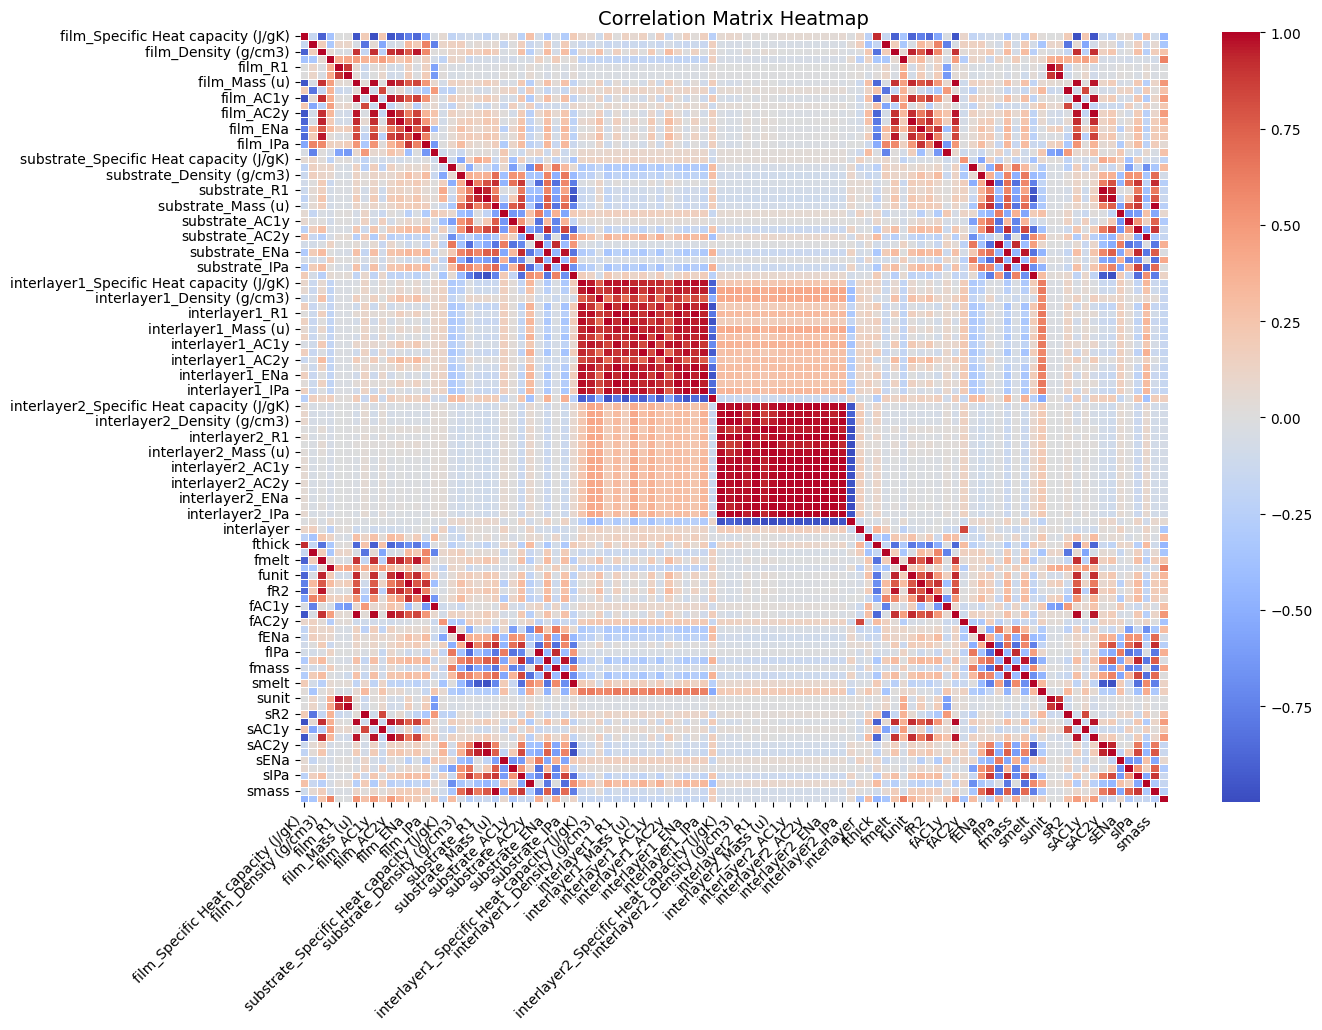

In [104]:
corr_matrix = train_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 8},
    )
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [105]:
X, y= train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [106]:
r_squared_threshold = 0.95
r_squared = corr_matrix ** 2
mask = np.triu(np.ones(r_squared.shape), k=1).astype(bool) # mask the upper triangle (including diagonal) to avoid redundancy
r_squared_triu = r_squared.where(mask)
drop_cols = [col for col in r_squared_triu.columns if any(r_squared_triu[col] > r_squared_threshold)]
X = X.drop(drop_cols, axis=1)
print(f"Columns dropped due to high correlation: {drop_cols}")

Columns dropped due to high correlation: ['film_AC1y', 'film_AC2y', 'substrate_Eb(eV/f.u.)', 'interlayer1_R1', 'interlayer1_R2', 'interlayer1_AC1y', 'interlayer1_AC2x', 'interlayer1_ENc', 'interlayer1_ENa', 'interlayer1_IPc', 'interlayer1_IPa', 'interlayer2_Melting point (K)', 'interlayer2_Density (g/cm3)', 'interlayer2_R1', 'interlayer2_R2', 'interlayer2_Mass (u)', 'interlayer2_AC1x', 'interlayer2_AC1y', 'interlayer2_AC2x', 'interlayer2_AC2y', 'interlayer2_ENc', 'interlayer2_ENa', 'interlayer2_IPc', 'interlayer2_IPa', 'interlayer2_Eb(eV/f.u.)', 'fheatcap', 'fmelt', 'fdensity', 'funit', 'fR1', 'fR2', 'fAC1x', 'fAC1y', 'fAC2x', 'fENc', 'fENa', 'fIPc', 'fIPa', 'fEb', 'fmass', 'sheatcap', 'smelt', 'sunit', 'sR1', 'sR2', 'sAC1x', 'sAC1y', 'sAC2x', 'sAC2y', 'sENc', 'sENa', 'sIPc', 'sIPa', 'sEb', 'smass']


In [107]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, y_test= test_df.iloc[:, :-1].drop(drop_cols, axis=1), test_df.iloc[:, -1]

In [108]:
def eval_reg_model(X_data, X_test, y_data, y_test, model):
    model.fit(X_data, y_data)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    model_name = type(model).__name__
    print("model: {},  rmse = {:.2f}, mae = {:.2f}, r2 = {:.2f}".format(model_name, rmse, mae, r2))

### Linear, Decision Tree, Support Vector, and Random Forest

In [109]:
eval_reg_model(X_train, X_valid, y_train, y_valid, LinearRegression())
eval_reg_model(X_train, X_valid, y_train, y_valid, DecisionTreeRegressor())
eval_reg_model(X_train, X_valid, y_train, y_valid, SVR(kernel="rbf"))
eval_reg_model(X_train, X_valid, y_train, y_valid, RandomForestRegressor())

model: LinearRegression,  rmse = 14.86, mae = 10.26, r2 = 0.68
model: DecisionTreeRegressor,  rmse = 8.65, mae = 4.38, r2 = 0.89
model: SVR,  rmse = 24.63, mae = 12.15, r2 = 0.13
model: RandomForestRegressor,  rmse = 7.66, mae = 4.23, r2 = 0.92


### Random Forest with GridSearchCV

In [112]:
search_space = {
    "n_estimators": [100, 200, 300],
    "max_features": [30, 35, 45],
    "max_depth": [4, 5, 6, 7]
    }
forest_reg = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=forest_reg, param_grid=search_space,
                           cv=5, scoring="r2", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
eval_reg_model(X_train, X_valid, y_train, y_valid, grid_search.best_estimator_)

{'max_depth': 7, 'max_features': 30, 'n_estimators': 300}
RandomForestRegressor(max_depth=7, max_features=30, n_estimators=300,
                      random_state=0)
0.892086685936927
model: RandomForestRegressor,  rmse = 6.64, mae = 4.25, r2 = 0.94


Cross-validation Average R2: 0.9104719558682808


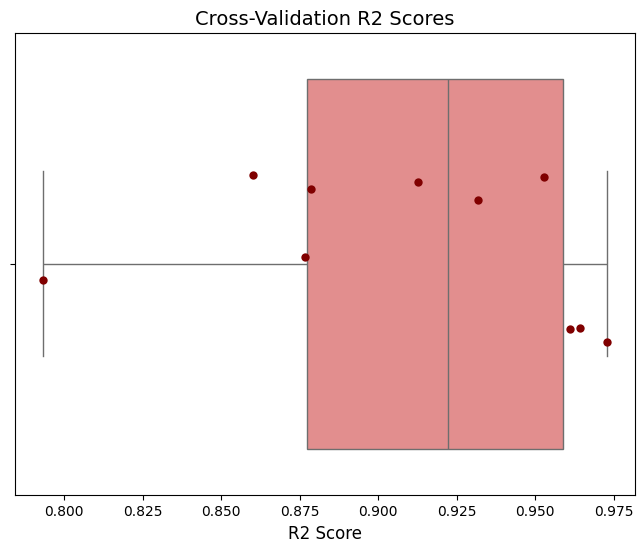

In [129]:
scores = cross_val_score(grid_search.best_estimator_, X, y, cv=10, scoring='r2')

print("Cross-validation Average R2:", scores.mean())

plt.figure(figsize=(8, 6))
sns.boxplot(x=scores, color='lightcoral')
sns.stripplot(x=scores, color='maroon', size=6, jitter=0.2)
plt.title('Cross-Validation R2 Scores', fontsize=14)
plt.xlabel('R2 Score', fontsize=12)
plt.show()

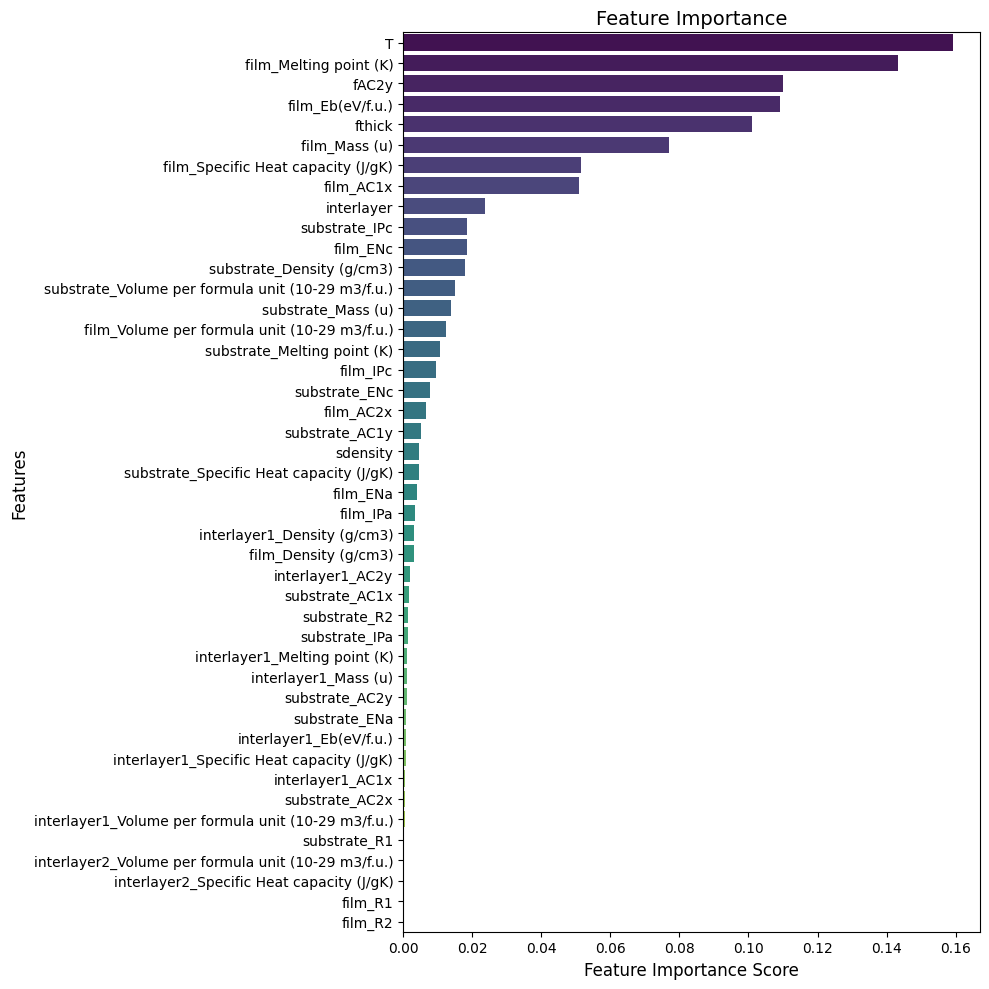

In [114]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_imp = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index, palette="viridis")
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [116]:
y_pred = grid_search.predict(X_test)

metrics = {
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": mean_squared_error(y_test, y_pred, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
    }

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

MSE: 83.4487
RMSE: 9.1350
MAE: 5.6046
R²: 0.8913


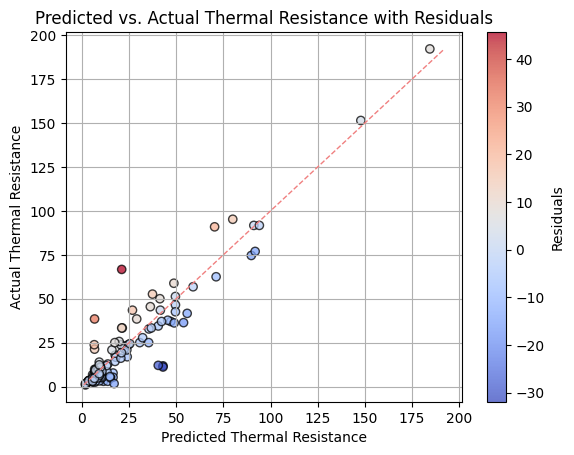

In [122]:
residuals = y_test.to_numpy().flatten() - y_pred
min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))

plt.scatter(y_pred, y_test, c=residuals, cmap='coolwarm', edgecolor='k', alpha=0.75)
plt.plot([min_val, max_val], [min_val, max_val], color='lightcoral', linestyle='--', linewidth=1)

plt.colorbar(label='Residuals')
plt.xlabel("Predicted Thermal Resistance")
plt.ylabel("Actual Thermal Resistance")
plt.title("Predicted vs. Actual Thermal Resistance with Residuals")
plt.grid(True)
plt.show()